In [1]:
import rebound
import reboundx
import numpy as np
from rebound import InterruptiblePool
%matplotlib inline
import matplotlib.pyplot as plt
def simcomp(par):
    run, mp, tau_inc, inc0, tmax, Nout, dt, damping = par
    np.random.seed(run)
    #inc0 = inc0 + 1.e-3*inc0*np.random.rand() 
    
    sim = rebound.Simulation()
    sim.integrator = "whfast"
    sim.dt = dt
    sim.add(m=1.)
    
    sim.add(m=mp,a=1.,inc=inc0, )
    sim.add(m=mp,a=2.,inc=0.2)
    sim.move_to_com() # Moves to the center of momentum frame  
    
    if damping is True:
        rebx = reboundx.Extras(sim)
        rebx.add_modify_orbits_direct()
    
        tau_incs = rebx.modify_orbits_direct.tau_inc
        tau_incs[1] = tau_inc    
    
    times = np.logspace(0,np.log10(tmax),Nout)
    ts, inc1, inc2, r1, r2, Eerr = np.zeros(len(times)), np.zeros(len(times)), np.zeros(len(times)), np.zeros(len(times)), np.zeros(len(times)), np.zeros(len(times))
    E0 = sim.calculate_energy()
    for i,time in enumerate(times):
        sim.integrate(time, exact_finish_time=0)
        ts[i] = sim.t
        o = sim.calculate_orbits()
        r1[i] = o[0].r
        r2[i] = o[1].r
        inc1[i] = o[0].inc
        inc2[i] = o[1].inc
        E = sim.calculate_energy()
        Eerr[i] = np.fabs(E-E0)/np.fabs(E0)

    sim = rebound.Simulation()
    sim.integrator = "ias15"
    sim.dt = 1.e-5
    sim.add(m=1.)
    
    np.random.seed(run)
    sim.add(m=mp,a=1.,inc=inc0)
    sim.add(m=mp,a=2.,inc=0.2)
    sim.move_to_com() # Moves to the center of momentum frame  
    
    if damping is True:
        rebx = reboundx.Extras(sim)
        rebx.add_modify_orbits_direct()
    
        tau_incs = rebx.modify_orbits_direct.tau_inc
        tau_incs[1] = tau_inc    
    
    i15inc1, i15inc2, i15r1, i15r2, i15Eerr = np.zeros(len(times)), np.zeros(len(times)), np.zeros(len(times)), np.zeros(len(times)), np.zeros(len(times))
    
    E0 = sim.calculate_energy()
    for i,time in enumerate(ts):
        sim.integrate(time, exact_finish_time=1)
        o = sim.calculate_orbits()
        i15r1[i] = o[0].r
        i15r2[i] = o[1].r
        i15inc1[i] = o[0].inc
        i15inc2[i] = o[1].inc
        E = sim.calculate_energy()
        i15Eerr[i] = np.fabs(E-E0)/np.fabs(E0)
        
    r1err = np.fabs(r1-i15r1)/i15r1
    r2err = np.fabs(r2-i15r2)/i15r2
    inc1err = np.fabs(inc1-i15inc1)/i15inc1
    inc2err = np.fabs(inc2-i15inc2)/i15inc2
    return [ts, r1err, r2err, inc1err, inc2err, Eerr, i15Eerr, mp, tau_inc]

In [2]:
def plotsimcomp(ax1,ax2,ax3, Nruns=1, Nout=1000, tmax=1e4, mp=1e-3, tau_inc=-1e3, inc0=0.1, dt=1.e-2, damping=True):
    params = [(run, mp, tau_inc, inc0, tmax, Nout, dt, damping) for run in range(Nruns)]
    pool = InterruptiblePool()
    res = pool.map(simcomp, params)

    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax3.set_xscale('log')
    ax3.set_yscale('log')
    
    for run in res:
        times = run[0]
        r1err = run[1]
        r2err = run[2]
        inc1err = run[3]
        inc2err = run[4]
        Eerr = run[5]
        i15Eerr = run[6]
        
        ax1.plot(times, r1err, alpha=1./Nruns)
        ax1.plot(times, r2err, alpha=1./Nruns)
        ax2.plot(times, inc1err, alpha=1./Nruns)
        ax2.plot(times, inc2err, alpha=1./Nruns)
        ax3.plot(times, Eerr, alpha=1./Nruns)
        ax3.plot(times, i15Eerr, alpha=1./Nruns)
   
    #ax1.set_ylim([1.e-16, 1.e-1])
    #ax2.set_ylim([1.e-16, 1.e-1])
    ax3.set_ylim([1.e-16, 1.e-1])
    #ax.set_aspect('equal')
    ax1.set_xlabel(r'Time', fontsize=24)
    ax2.set_xlabel(r'Time', fontsize=24)
    ax3.set_xlabel(r'Time', fontsize=24)
    ax1.set_ylabel(r'Relative orb. radius err', fontsize=24)
    ax2.set_ylabel(r'Relative inc. error', fontsize=24)
    ax3.set_ylabel(r'Relative E error', fontsize=24)
    #ax.tick_params(labelsize=12)

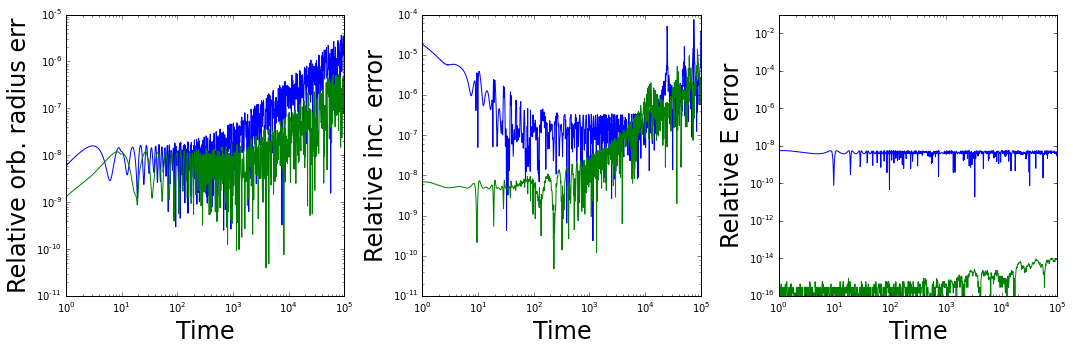

In [3]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1,ncols=3, figsize=(15,5))
plotsimcomp(ax1,ax2,ax3,Nruns=1,mp=1e-3, inc0 = 1.e-6, tau_inc=-1e5, tmax=1e5,dt=1.e-2, damping=False)
plt.tight_layout()

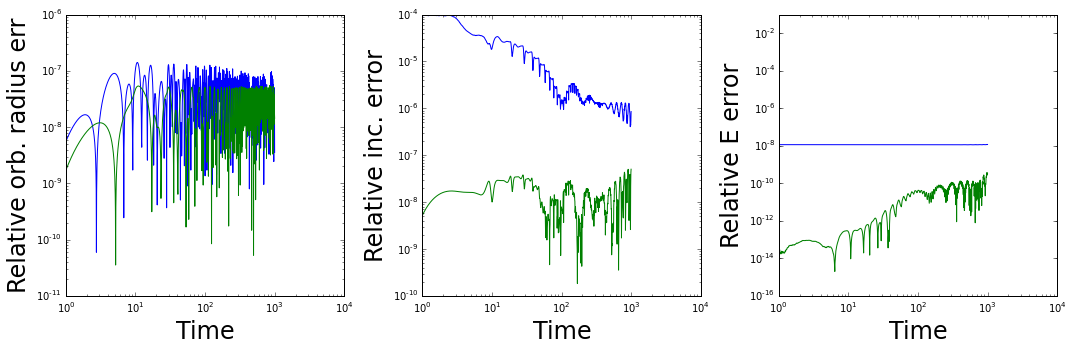

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1,ncols=3, figsize=(15,5))
plotsimcomp(ax1,ax2,ax3, Nruns=1,mp=1e-3, inc0 = 1.e-6, tau_inc=-1e5, tmax=1e3,dt=1.e-4, damping=True)
plt.tight_layout()

In [1]:
import rebound
import reboundx
import numpy as np
from rebound import InterruptiblePool
%matplotlib inline
import matplotlib.pyplot as plt

def getstr(dt):
    return "{:.0e}".format(dt)
def i15(par):
    run, mp, tau_inc, inc0, tmax, Nout, dt, damping = par
    np.random.seed(run)
    #inc0 = inc0 + 1.e-3*inc0*np.random.rand() 
    
    sim = rebound.Simulation()
    sim.integrator = "ias15"
    sim.ri_ias15.epsilon = 0.
    sim.dt = dt
    sim.add(m=1.)
    
    sim.add(m=mp,a=1.,inc=inc0)
    sim.add(m=mp,a=2.,inc=0.2)
    sim.move_to_com() # Moves to the center of momentum frame  
    
    if damping is True:
        rebx = reboundx.Extras(sim)
        rebx.add_modify_orbits_direct()
    
        tau_incs = rebx.modify_orbits_direct.tau_inc
        tau_incs[1] = tau_inc    
    
    times = np.logspace(0,np.log10(tmax),Nout)
    ts, inc1, inc2, r1, r2, E = np.zeros(len(times)), np.zeros(len(times)), np.zeros(len(times)), np.zeros(len(times)), np.zeros(len(times)), np.zeros(len(times))
    for i,time in enumerate(times):
        sim.integrate(time, exact_finish_time=1)
        ts[i] = sim.t
        o = sim.calculate_orbits()
        r1[i] = o[0].r
        r2[i] = o[1].r
        inc1[i] = o[0].inc
        inc2[i] = o[1].inc
        E[i] = sim.calculate_energy()

    predinc = [inc0*np.exp(t/tau_inc) for t in ts]
    return [times, r1, r2, inc1, inc2, E, predinc]

In [2]:
def plotEerr(ax, Ndts, Nout=1000, tmax=1e4, mp=1e-3, tau_inc=-1e3, inc0=0.1, damping=True):
    dts = np.logspace(-Ndts, -1, Ndts)
    labels = ["dt={0}".format(getstr(dt)) for dt in dts]
    params = [(1, mp, tau_inc, inc0, tmax, Nout, dt, damping) for dt in dts]
    pool = InterruptiblePool()
    res = pool.map(i15, params)

    ax.set_xscale('log')
    ax.set_yscale('log')
    
    for i, dtrun in enumerate(res):
        times = dtrun[0]
        inc = dtrun[3]
        Eerr = dtrun[5]
        predinc = dtrun[6]
        
        incerr = [np.fabs(inc[j]-predinc[j])/predinc[j] for j in range(len(times))]
        ax.plot(times, incerr, label=labels[i])
   
    ax.legend()
    ax.set_ylim([1.e-16, 1.e-1])
    ax.set_xlabel(r'Time', fontsize=24)
    ax.set_ylabel(r'Relative inc error', fontsize=24)
    #ax.tick_params(labelsize=12)

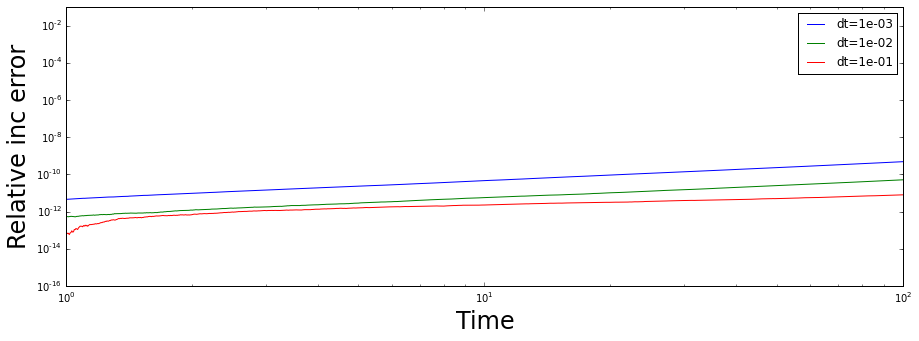

In [11]:
fig, ax = plt.subplots(figsize=(15,5))
plotEerr(ax, Ndts=3,mp=1e-6, inc0 = 1.e-1, tau_inc=-1000, tmax=1e2, damping=True)


In [2]:
def ploti15toi15(ax1,ax2,ax3, Nruns=1, Nout=1000, tmax=1e4, mp=1e-3, tau_inc=-1e3, inc0=0.1, dt=1.e-2, damping=True, color='r'):
    params = [(1, mp, tau_inc, inc0, tmax, Nout, dt, damping)]
    pool = InterruptiblePool()
    res1 = pool.map(i15, params)
    params2 = [(1, mp, tau_inc, inc0, tmax, Nout, dt/10., damping)]
    res2 = pool.map(i15, params2)

    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax3.set_xscale('log')
    ax3.set_yscale('log')
    
    res1 = res1[0]
    res2 = res2[0]
    
    times = res1[0]
    r1err = np.fabs(np.array(res1[1])-np.array(res2[1]))/np.array(res2[1])
    r2err = np.fabs(np.array(res1[2])-np.array(res2[2]))/np.array(res2[2])
    inc1err = np.fabs(np.array(res1[3])-np.array(res2[3]))/np.array(res2[3])
    inc2err = np.fabs(np.array(res1[4])-np.array(res2[4]))/np.array(res2[4])
    Eerr = np.fabs(np.array(res1[5])-np.array(res2[5]))/np.fabs(np.array(res2[5]))
     
    ax1.plot(times, r1err, color=color, label=getstr(dt))
    #ax1.plot(times, r2err, color=color, linestyle='--')
    ax2.plot(times, inc1err, color=color, label=getstr(dt))
    #ax2.plot(times, inc2err, color=color, linestyle='--')
    ax3.plot(times, Eerr, color=color, label=getstr(dt))
   
    #ax1.set_ylim([1.e-16, 1.e-1])
    #ax2.set_ylim([1.e-16, 1.e-1])
    ax3.set_ylim([1.e-16, 1.e-1])
    #ax.set_aspect('equal')
    ax1.set_xlabel(r'Time', fontsize=24)
    ax2.set_xlabel(r'Time', fontsize=24)
    ax3.set_xlabel(r'Time', fontsize=24)
    ax1.set_ylabel(r'Relative orb. radius err', fontsize=24)
    ax2.set_ylabel(r'Relative inc. error', fontsize=24)
    ax3.set_ylabel(r'Relative E error', fontsize=24)
    #ax.tick_params(labelsize=12)

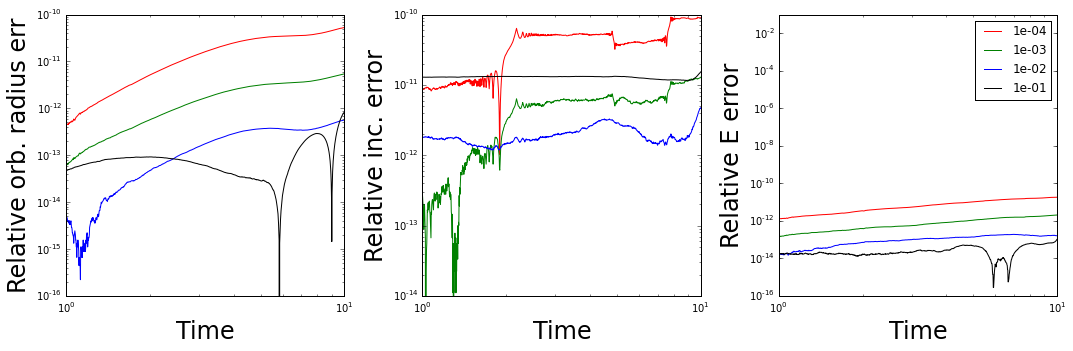

In [4]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1,ncols=3, figsize=(15,5))
Ndts = 4
dts = np.logspace(-Ndts, -1, Ndts)
colors = ['r', 'g', 'b', 'k']
for i, dt in enumerate(dts):
    ploti15toi15(ax1,ax2,ax3,Nruns=1,mp=1e-6, inc0 = 1.e-1, tau_inc=-1000., tmax=1e1,dt=dt, damping=True, color=colors[i])

ax3.legend()
plt.tight_layout()

In [8]:
import rebound
import reboundx
import numpy as np
from rebound import InterruptiblePool
%matplotlib inline
import matplotlib.pyplot as plt
def i15dt(par):
    run, mp, tau_inc, inc0, tmax, Nout, dt, damping = par
    np.random.seed(run)
    #inc0 = inc0 + 1.e-3*inc0*np.random.rand() 
    
    sim = rebound.Simulation()
    sim.integrator = "ias15"
    sim.dt = dt
    sim.add(m=1.)
    
    sim.add(m=mp,a=1.,inc=inc0)
    #sim.add(m=mp,a=2.,inc=0.2)
    sim.move_to_com() # Moves to the center of momentum frame  
    
    if damping is True:
        rebx = reboundx.Extras(sim)
        rebx.add_modify_orbits_direct()
    
        tau_incs = rebx.modify_orbits_direct.tau_inc
        tau_incs[1] = tau_inc    
    
    times = np.logspace(0,np.log10(tmax),Nout)
    dts = np.zeros(len(times))
    for i,time in enumerate(times):
        sim.integrate(time, exact_finish_time=0)
        dts[i] = sim.dt_last_done
  
    print(dts)
    print(min(dts))
    
run=1
mp=1e-3
tau_inc=-1e5
inc0 = 1.e-1
tmax=1e1
Nout=100
dt=1.e-5
damping=False
par = (run,mp,tau_inc,inc0,tmax,Nout,dt,damping)
i15dt(par)

[ 0.17651359  0.17651359  0.0057041   0.04491354  0.04491354  0.00678744
  0.02445198  0.00834681  0.03340374  0.006913    0.03809013  0.00310792
  0.02309682  0.05746098  0.05746098  0.00921225  0.02630123  0.04241687
  0.04241687  0.03088646  0.05147636  0.05147636  0.02370256  0.03824939
  0.01915248  0.0180602   0.06355694  0.06355694  0.02604581  0.04611248
  0.02666606  0.03199271  0.0568532   0.0568532   0.03362635  0.06629363
  0.00094637  0.11312069  0.11312069  0.008567    0.03626988  0.08366666
  0.08366666  0.07609768  0.01605702  0.06273013  0.04265257  0.02829591
  0.11222329  0.11222329  0.07116913  0.03865928  0.0722907   0.02831403
  0.09066325  0.01712151  0.0780224   0.04794835  0.05593408  0.04716802
  0.12751791  0.12751791  0.05889552  0.13755519  0.13755519  0.12393605
  0.0108052   0.0893163   0.08844925  0.09420214  0.0267101   0.17334237
  0.17334237  0.05689181  0.17554092  0.17554092  0.17611743  0.17611743
  0.10808546  0.07141728  0.17036123  0.07441356  0

In [ ]:
r1err = np.fabs(r1-i15r1)/i15r1
    r2err = np.zeros(len(times)) #np.fabs(r2-i15r2)/i15r2
    inc1err = np.fabs(inc1-i15inc1)/i15inc1
    inc2err = np.zeros(len(times)) #np.fabs(inc2-i15inc2)/i15inc2
    return [ts, r1err, r2err, inc1err, inc2err, Eerr, i15Eerr, mp, tau_inc]